# ベイジアン 固定効果モデル

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   island_names              1900 non-null   object 
 1   years                     1900 non-null   int64  
 2   island_ids                1900 non-null   int64  
 3   region_codes              1900 non-null   object 
 4   region_names              1900 non-null   object 
 5   prefecture_codes          1900 non-null   int64  
 6   populations               1697 non-null   float64
 7   treatment_group           1900 non-null   int64  
 8   treatment_group_mainland  1900 non-null   int64  
 9   year_bridges_opened       1900 non-null   int64  
 10  after_treated             1900 non-null   int64  
 11  year_connect_mainland     1900 non-null   int64  
 12  after_treated_mainland    1900 non-null   int64  
 13  income                    1401 non-null   float64
 14  prefectu

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


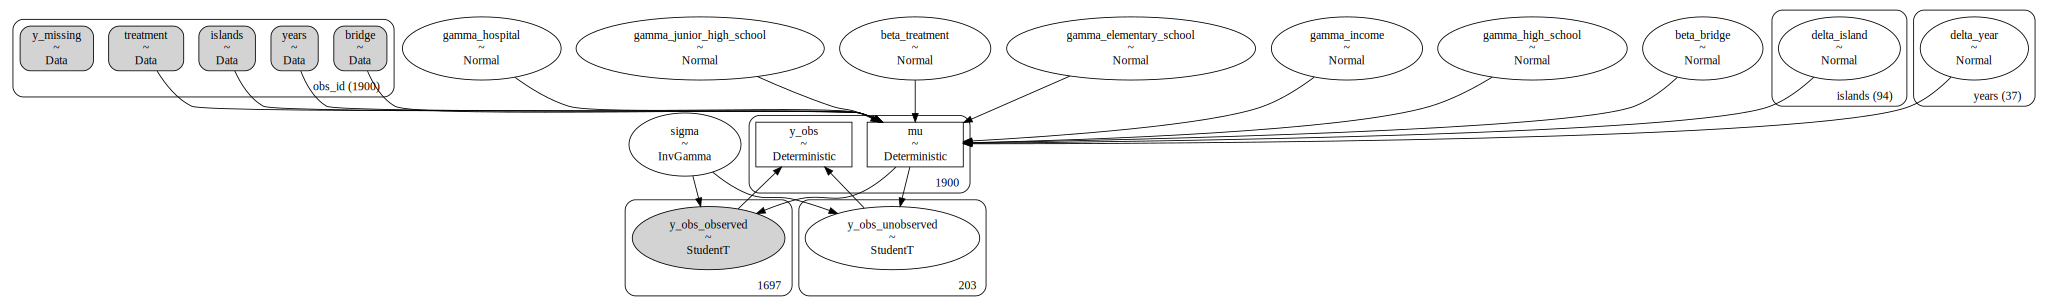

In [ ]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

COORDS = {
    'islands': df['island_ids'].unique(),
    'years': df['years'].unique(),
    'obs_id': df.index
}

y_values = df['populations'].values
log_income = np.log(df['income'])
elementary_school = df['elementary_school']
junior_high_school = df['junior_high_school']
high_school = df['high_school']
hospital = df['hospital']

with pm.Model(coords=COORDS) as model:
    # Data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    treatment = pm.Data('treatment', df['treatment_group'], dims='obs_id')
    bridge = pm.Data('bridge', df['after_treated'], dims='obs_id')

    # Priors
    beta_treatment = pm.Normal('beta_treatment', mu=0, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0, sigma=100)
    gamma_income = pm.Normal('gamma_income', mu=0, sigma=100)
    gamma_elementary_school = pm.Normal('gamma_elementary_school', mu=0, sigma=100)
    gamma_junior_high_school = pm.Normal('gamma_junior_high_school', mu=0, sigma=100)
    gamma_high_school = pm.Normal('gamma_high_school', mu=0, sigma=100)
    gamma_hospital = pm.Normal('gamma_hospital', mu=0, sigma=100)
    delta_islands = pm.Normal('delta_island', mu=0, sigma=100, dims='islands')
    delta_years = pm.Normal('delta_year', mu=0, sigma=100, dims='years')
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # linear model
    covariate = pm.Deterministic(
        'covariate',
        gamma_income * log_income + gamma_elementary_school * elementary_school + gamma_junior_high_school * junior_high_school + gamma_high_school * high_school + gamma_hospital * hospital
    )
    
    mu = pm.Deterministic(
        'mu',
        beta_treatment * treatment + beta_bridge * bridge + covariate + delta_islands[islands] + delta_years[years]
    )

    # Likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=y_values)
    y_missing = pm.Data('y_missing', df['populations'].isnull(), dims='obs_id')

# モデルの視覚化
pm.model_to_graphviz(model)

In [ ]:
with model:
    idata = pm.sample(
        draws=2000,
        tune=4000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        chains=2,
        cores=4,
        init="adapt_diag",
        target_accept=.998,
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

## アウトプットの保存

In [23]:
az.to_netcdf(idata, 'fixed_effects.nc')

'fixed_effects.nc'

## アウトプットのエクスポート

In [8]:
idata = az.from_netcdf('fixed_effects.nc')

In [ ]:
az.plot_trace(idata, figsize=(18, 15))  # サイズを調整
az.summary(idata)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite val

KeyboardInterrupt: 

In [27]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_bridge'] > 0)
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
prob_beta_income_positive = np.mean(posterior_samples['gamma'] > 0)
print(f"Pr(gamma_income > 0) = {prob_beta_income_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_bridge > 0) = 0.9205
Pr(gamma_income > 0) = 0.1450
Pr(sigma > 0) = 1.0000
